In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import re
import time
from re import *
import spacy
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

def get_text_segments(text: str):
    '''
    Extracts text segments from the given text by removing special characters and
    splitting the text at punctuation marks.
    
    Args:
        text (str): The input text.
    
    Returns:
        list: A list of cleaned text segments.
    '''
    
    # If there is no content, return empty list
    if isinstance(text, float):
        return []
    
    # Convert text to lowercase and normalize
    text_ = text.lower()
    
    # Clean special signs and normalize
    text_ = re.sub('[!-&\(-+/<=>@{-¿\[-`÷€]', '', text_)
    text_ = re.sub("[’'\-]", ' ', text_)
    
    # Replace multiple spaces
    text_ = re.sub('[ ]+', ' ', text_)

    # Split the text at each punctuation sign
    segments = re.findall('([^!.,;:?«»"\(\)–—]+)', text_)

    # Remove spaces at start and end of the string
    segments = [seg.strip() for seg in segments]

    # Remove empty segments
    segment_length = [len(seg) for seg in segments]
    segments = np.array(segments)[np.array(segment_length) > 0]
    
    return segments

def unroll(nested_list: list):
    '''
    Small function used to flatten a nested list.
    
    Args:
        nested_list (list): The input nested list.
    
    Returns:
        list: A flattened list.
    '''
    return [item for list_ in nested_list for item in list_]

def get_ngrams(text, n: int = 2):
    '''
    Extracts n-grams from the given text.
    
    Args:
        text (str): The input text.
        n (int): The size of the n-grams.
    
    Returns:
        list: A list of n-grams.
    '''
    
    # Compute speech segments (e.g. sentences)
    segments = get_text_segments(text)
    
    # For each segment, iterate over the text and store the ngrams as tuples
    ngrams = []
    for segment in segments:
        tokens = segment.split(' ')
        ngrams.append([tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)])
        
    return unroll(ngrams)

def count_ngrams(df, col: str = 'content', n: int = 1):
    '''
    Counts all the occurrences of n-grams in a DataFrame.
    
    Args:
        df (DataFrame): The input DataFrame.
        col (str): The column name containing the text.
        n (int): The length n of the n-grams.
    
    Returns:
        DataFrame: A DataFrame containing unique n-grams and their counts.
    '''
    
    # Initialize timer
    start = time.time()
    
    # Recover all n-grams and store them in a new column 
    df[f'{n}-gram'] = df['content'].apply(get_ngrams, n=n)
    
    # Find all unique n-grams and count the number of occurences
    ngram_list = unroll(df[f'{n}-gram'].values.tolist())
    unq, cnt = np.unique(ngram_list, return_counts=True, axis=0)
    print(f'{len(ngram_list)} {n}-grams found in total, corresponding to {len(unq)} unique {n}-grams.')
    
    # Storing the results in a dataframe
    unq = [tuple(it) for it in unq]
    df_ngram = pd.DataFrame({'unique': unq, 'count': cnt}).sort_values(by='count', ascending=False)

    print('Time elapsed:', time.time()-start)
    
    return df_ngram

def count_ngram_occurrences(df, ngram: tuple):
    '''
    Count the occurrences of the given ngram in a dataframe and group the counts by year.
    
    Args:
        df (DataFrame): The input dataframe containing at least n-gram columns and a 'year' column.
        ngram (tuple): The n-gram tuple to be counted in the dataframe.
        
    Returns:
        DataFrame: A new dataframe with n-gram occurrences grouped by year.
    '''
    
    def count_ngram(ngrams, ngram):
        '''
        Counts the number of times where the given ngram appears in a list of ngrams.
        '''
        vector = np.empty(len(ngrams), dtype=object)
        vector[:] = ngrams

        return np.sum(vector == ngram)
    
    if isinstance(ngram, str):
        len_ngram = 1
        ngram = (ngram,)
    else:
        len_ngram = len(ngram)
    
    # Create a numpy array with the ngram to count
    item = np.empty(1, dtype=object)
    item[:] = [ngram]

    # Count the number of occurences of the ngram (item) in each article
    df['occurences'] = df[f'{len_ngram}-gram'].apply(count_ngram, ngram=item)

    # Store the output in a new dataframe grouped by year
    df_ngram_by_year = df[['occurences', 'year']].groupby(by='year').sum()
    df_ngram_by_year = df_ngram_by_year.rename(columns = {'occurences': str(ngram)})

    # Reset df dataframe
    df = df.drop(columns = ['occurences'])
    
    return df_ngram_by_year

In [ ]:
print(" /!\ il faut définir l import impresso à utiliser /!\ ")

In [14]:
nlp_fr = spacy.load('fr_core_news_lg')
df = pd.read_csv('.\\roger_masson.csv', sep=';')
articles = df['content'].dropna().values.tolist()[:550]

documents, tokens = [], []
for article in articles:
    words = findall('([a-zà-ÿ]+)', article.lower())
    tokens += words
    documents.append(words)

vocabulaire = pd.Series(tokens).value_counts()[20:]
vocabulaire = vocabulaire [vocabulaire >= 3].sort_index().keys()

one_hot = np.zeros((len(documents), len(vocabulaire)))
for index, document in enumerate(documents):
    for token in document:
        one_hot[index][int(np.argmax(vocabulaire == token))] = 1

lda = LatentDirichletAllocation(n_components=7, random_state=0) # il faut jouer sur le nombre de clusters mais jsp comment
res = lda.fit_transform(one_hot)

# Mots les plus fréquents du cluster 5
for i in np.flip(np.argsort(lda.components_[5]))[:20]:
    print(vocabulaire[i], end=', ')

# Mots les plus caractéristiques du cluster 5
type_attribution = lda.transform(np.identity(len(vocabulaire)))
for t in vocabulaire[np.flip(np.argsort(type_attribution[:,5]))[:20]]:
    print(t, end=', ')

#les articlesles plus represenatifs
for art_id in np.flip(np.argsort(res[:, 5]))[:3]:
    print(articles[art_id], end='\n\n')

data_ngrams = {}

for n in range(1, 6):
    data_ngrams[n] = count_ngrams(df, n=n)


data_ngrams[3].head(30)


n, ce, masson, aa, par, mais, pas, pour, sur, s, ne, plus, son, on, chef, qu, sa, se, y, avec, aire, cherchant, tromper, rendent, foote, patient, parallèle, délais, prospective, préférer, pommes, outrance, sor, nouer, duplain, prolonger, détachements, accélérer, travailla, gnements, UN OUVRAGE TRES DISCUTABLE QUI DÉFORME LA RÉALITÉ La Suisse pendant la deuxième guerre mondiale par Georges DUPLAIN MJOHN KIMCHE, né et élevé à Saint-Gall, a fait carrière de journaliste à Londres, au service de journaux britanniques ou du Moyen-Orient. Il a toujours conservé la lité suisse. Voici quelques années, il s'est mis à étudier la situation de la Suisse durant la dernière guerre mondiale, et le rôle des autorités civiles et militaires de notre pays. Il a puisé sa documentation d'une part dans les textes officiels publiés : rapport du général et de ses collaborateurs, ainsi que dans les mémoires de Bernard Barbey « Q. G. » du général ; d'autre part, auprès de certains officiers de l'armée suisse don

,unique,count
46152,"(de, l, armée)",290
176961,"(service, de, renseignements)",276
30715,"(colonel, brigadier, masson)",270
110999,"(le, conseil, fédéral)",242
110775,"(le, colonel, masson)",242
110726,"(le, colonel, brigadier)",207
130607,"(n, est, pas)",177
47283,"(de, la, suisse)",173
62812,"(du, service, de)",170
28846,"(chef, du, service)",151


In [15]:
data_ngrams[5].head(30)

,unique,count
26275,"(chef, du, service, de, renseignements)",84
58208,"(du, service, de, renseignements, de)",58
166232,"(service, de, renseignements, de, l)",57
46939,"(de, renseignements, de, l, armée)",46
45877,"(de, notre, service, de, renseignements)",41
104005,"(le, chef, du, département, militaire)",40
104174,"(le, colonel, brigadier, roger, masson)",35
42934,"(de, l, état, major, général)",31
98473,"(la, fin, de, la, guerre)",31
26138,"(chef, de, notre, service, de)",25


In [6]:

data_ngrams[4].head(30)

,unique,count
113850,"(le, colonel, brigadier, masson)",160
63846,"(du, service, de, renseignements)",128
28803,"(chef, du, service, de)",100
28776,"(chef, du, département, militaire)",77
62271,"(du, colonel, brigadier, masson)",76
181595,"(service, de, renseignements, de)",69
138462,"(notre, service, de, renseignements)",67
30529,"(colonel, brigadier, roger, masson)",64
51378,"(de, renseignements, de, l)",62
171745,"(renseignements, de, l, armée)",60


In [ ]:
print(" /!\il faut définir le n-gram à utiliser  et remplir list-date si vous voulez/!\ ")

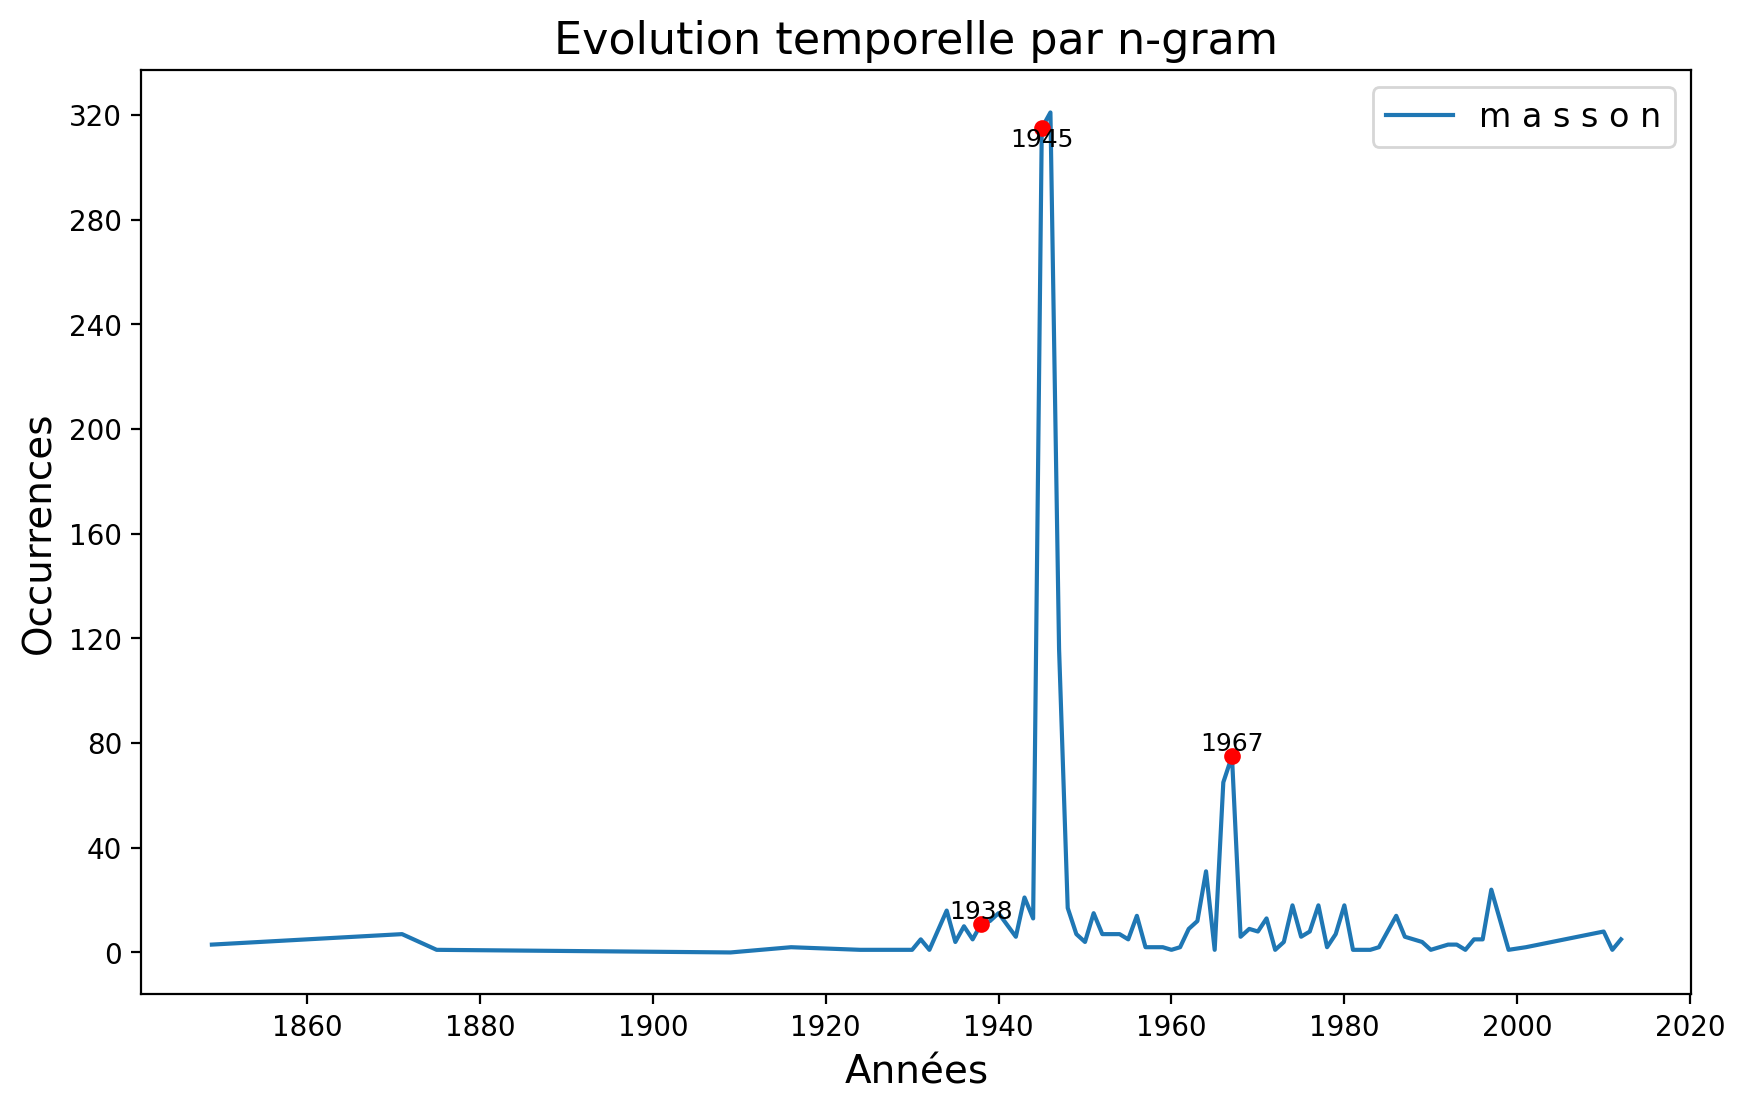

In [86]:

list_date=[1938,1945,1967]

# Observe and display the temporal evolution of a specific ngram
#ngram = ('la', 'chaux', 'de', 'fonds')
ngram=('masson')
df_ngram_by_year = count_ngram_occurrences(df, ngram)

# Customize the appearance of the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
df_ngram_by_year.plot(ax=ax, linestyle='-')

#ajouter un point rouge par date
i=0
for date in list_date:
    loc='bottom' if i%2==0 else 'top'
    date2=df_ngram_by_year.loc[date] if date in df_ngram_by_year.index else 0
    ax.plot(date,date2, marker='o', markersize=5, color="red")
    #make sure the text doesn't overlap with other dates
    ax.text(date, date2, date, fontsize=9, horizontalalignment='center', verticalalignment=loc)
    i+=1

# Add labels, a title, gridlines, and a legend
ax.set_xlabel('Années', fontsize=14)
ax.set_ylabel('Occurrences', fontsize=14)
ax.set_title(f'Evolution temporelle par n-gram', fontsize=16)
ax.legend([f'{" ".join(ngram)}'], loc='best', fontsize=12)

# Format the y-axis ticks
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

In [77]:
#find sentences containing the ngram and the sentence before and after
def find_sentences(articles, ngram: tuple):
    W=[]
    for article in articles:
        if " ".join(ngram) in article.lower():
            print(articles.index(article))
            print(article + '\n\n')
            words = re.findall(r'[^.?!]*\. '+r'[^.?!]*\ ' +' '.join(ngram)+r' [^.?!]*\. '+r'[^.?!]*\.', article.lower())
            if words==[]:
                words=re.findall(r'[^.?!]*\. '+r'[^.?!]*\ ' +' '.join(ngram)+r' [^.?!]*\.', article.lower()) #si c'est dans une dernière phrase
                if words==[]:
                    words=re.findall(r'[^.?!]*\ ' +' '.join(ngram)+r' [^.?!]*\. '+r'[^.?!]*\.', article.lower())#si c'est dans une première phrase
                    if words==[]:
                        words=re.findall(' '.join(ngram)+r' [^.?!]*\. '+r'[^.?!]*\.', article.lower())#si c est le debut d'une première phrase
            
            for word in words:
                index=article.lower().index(word)
                W.append(article[index: index+len(word)])
    return W

articles = df['content'].dropna().values.tolist()
seg=find_sentences(articles, ('chaux-de-fonds',''))
print(seg)

47
Les communes du canton ont célébré avec ferveur le Centenaire de ia République Le conseiller fédéral Rodolphe Rubattel à la Chaux-de-Fonds (sp) Dès samedi après-midi, une animation peu coutumlère régnait à la rue pold-Robert, qui, fort Joliment pavolsée, avait revêtu son aspect des grands Jours. Peu après 13 heures, la foule se massa sur la place de la gare. A l'arrivé e du conseiller fédéral Rodolphe Rubattel, du Juge fédéral Albert Rai s et de M. Eugène Péqulgnot, secrétaire général du département de l'économie publique, le cortège se forma, conduit par les « Ànnes-Réunles » et un détach : ment de soldats de la société des sous-olflclers Le Conseil communal reçut ses hôtes au Musée historique, puis le souper suivi de la partie officielle se déroula au Cercle du sapin. De nombreux orateurs prirent la parole, saluèrent nos Invités et, en les remerciant, relevèrent combien leur présence donnait d'importance à la manifestation. Dans le discours qu'il prononça, M. Rubattel parla de l'e